# Test Machine learning algorithms - No hyperparameter tuning

In [1]:
# Import librairies
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix,classification_report
from yellowbrick.text import TSNEVisualizer


import pickle
import shutil
import sys
import warnings

from utils_text_processing import *

2023-04-04 07:14:42.672621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 07:14:43.082582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-04 07:14:43.485080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-04 07:14:43.485375: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

gensim version: 4.3.1
tensorflow version: 2.12.0
Num GPUs Available:  0
is tf built with cuda: True


[nltk_data] Downloading package words to /home/aurelie/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aurelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aurelie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


USE model %s loaded


In [2]:
nltk.download("words")
nltk.download("stopwords")
nltk.download("omw-1.4")
nlp = spacy.load("fr_core_news_md")

[nltk_data] Downloading package words to /home/aurelie/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aurelie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/aurelie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
output_path = path + "/outputs"
fig_path = path + "/figures"

In [4]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [5]:
# Activation PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

In [6]:
# Paramètres graphiques
%matplotlib inline
rc = {
    'font.size': 14,
    'font.family': 'Arial',
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(font='Arial', rc=rc)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })
sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)

In [7]:
# Import data
df = pd.read_csv(os.path.join(data_path, 'working_data_rameau.csv'), index_col=0)
print(df.shape)
df.head()

(89416, 11)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,DDC,TEF_LABEL,test_tiret,rameau_list,rameau_list_unstack
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,840.0,Littérature de langues romanes. Littérature fr...,False,['Culture populaire;Diffusion de la culture;Po...,"['Culture populaire', 'Diffusion de la culture..."
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement dune c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",150.0,Psychologie,False,['Complexe de castration;Psychanalyse;Rêves'],"['Complexe de castration', 'Psychanalyse', 'Rê..."
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",840.0,Littérature de langues romanes. Littérature fr...,False,['Culture'],['Culture']
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",100.0,"Philosophie, psychologie",False,['Structuralisme'],['Structuralisme']
4,000026352,La Destruction du temple,"Oswald tire sur Kennedy. Jusque-là, c'est bon,...",Science-fiction américaine -- Traductions fran...,830,La Destruction du temple Oswald tire sur Kenne...,830.0,Littérature allemande,True,['Science-fiction américaine -- Traductions fr...,"['Science-fiction américaine', 'Traductions fr..."


INFO:pycodestyle:2:80: E501 line too long (81 > 79 characters)


In [8]:
# add words
add_words = [
        "la",
        "de",
        "le",
        "les",
        "l",
        "au",
        "du",
        "ouvrage",
        "auteur",
        "livre",
        "quatrieme",
        "couv"
]

In [9]:
# Select sample of data
n_sample = 50000
df_sample = df.sample(n=n_sample)
df_sample.shape

(50000, 11)

In [10]:
# Preproces des résumés
df_sample['DESCR_processed'] = df_sample['DESCR'].apply(
    lambda x: preprocess_text(
        x,
        add_words=add_words,
        numeric=False,
        stopw=True,
        stem=False,
        lem=True))

In [11]:
# Split data
y = df_sample["rameau_list_unstack"]
X = df_sample["DESCR_processed"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [12]:
# Check size
print(f"train dataset size : {len(y_train)}")
print(f"test dataset size : {len(y_test)}")

train dataset size : 33500
test dataset size : 16500


In [13]:
# Convert the categorical labels to Multi Label Encodings
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(y_train)
test_labels = mlb.transform(y_test)

In [14]:
# Create TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(X_train)
vectorised_test_documents = vectorizer.transform(X_test)

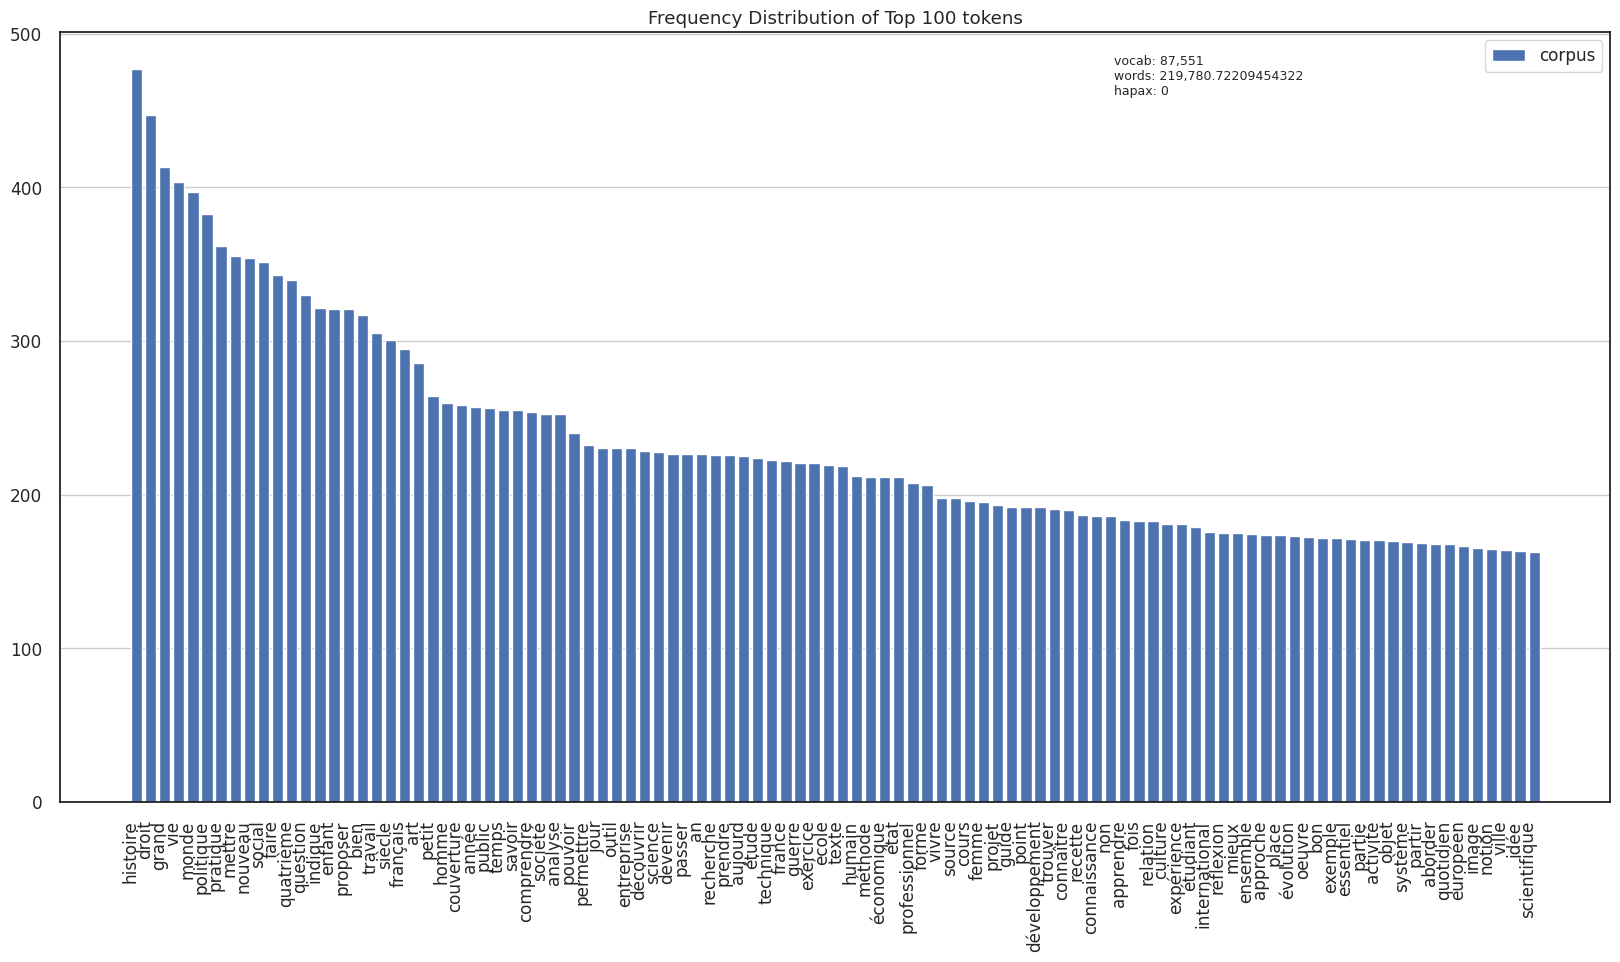

<Axes: title={'center': 'Frequency Distribution of Top 100 tokens'}>

In [15]:
# Visualize Word Frequency Distribution
from yellowbrick.text import FreqDistVisualizer
plt.figure(figsize=(20, 10))
features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, n=100, orient="v")
visualizer.fit(vectorised_train_documents)
visualizer.show()

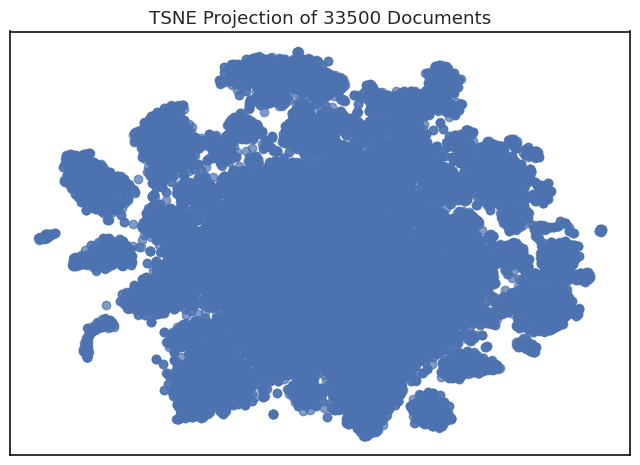

<Axes: title={'center': 'TSNE Projection of 33500 Documents'}>

In [16]:
# Visualize the dataset with T-SNE
tsne = TSNEVisualizer()
tsne.fit(vectorised_train_documents)
tsne.show()

In [29]:
# Train and Evaluate Classifiers
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, hamming_loss, coverage_error, brier_score_loss,
    label_ranking_average_precision_score, label_ranking_loss)


ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions, compare="macro_f1"):

    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')

    hamLoss = hamming_loss(test_labels, predictions)
    lrap = label_ranking_average_precision_score(test_labels, predictions)
    lrl = label_ranking_loss(test_labels, predictions)
    cov_error = coverage_error(test_labels, predictions)
    EMR = np.all(test_labels == predictions, axis=1).mean()
    #brier = brier_score_loss(test_labels, predictions)

    # Print result
    print("------" + modelName + " Model Metrics-----")
    print(f"Accuracy: {accuracy:.4f}\nHamming Loss: {hamLoss:.4f}\nCoverage Error: {cov_error:.4f}")
    #print(f"Brier Score: {brier:.4f}")
    print(f"Exact Match Ratio: {EMR:.4f}\nRanking Loss: {lrl:.4f}\nLabel Ranking avarge precision (LRAP): {lrap:.4f}")
    print(f"Precision:\n  - Macro: {macro_precision:.4f}\n  - Micro: {micro_precision:.4f}")
    print(f"Recall:\n  - Macro: {macro_recall:.4f}\n  - Micro: {micro_recall:.4f}")
    print(f"F1-measure:\n  - Macro: {macro_f1:.4f}\n  - Micro: {micro_f1:.4f}")

    # Store F1
    ModelsPerformance[modelName] = eval(compare)

INFO:pycodestyle:10:1: E302 expected 2 blank lines, found 1
INFO:pycodestyle:14:80: E501 line too long (80 > 79 characters)
INFO:pycodestyle:18:80: E501 line too long (80 > 79 characters)
INFO:pycodestyle:27:5: E265 block comment should start with '# '
INFO:pycodestyle:31:80: E501 line too long (100 > 79 characters)
INFO:pycodestyle:32:5: E265 block comment should start with '# '
INFO:pycodestyle:33:80: E501 line too long (118 > 79 characters)
INFO:pycodestyle:34:80: E501 line too long (92 > 79 characters)
INFO:pycodestyle:35:80: E501 line too long (83 > 79 characters)


In [30]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

knnClf = KNeighborsClassifier()

knnClf.fit(vectorised_train_documents, train_labels)
knnPredictions = knnClf.predict(vectorised_test_documents)
metricsReport("knn", test_labels, knnPredictions)

------knn Model Metrics-----
Accuracy: 0.0252
Hamming Loss: 0.0853
Coverage Error: 90.0033
Exact Match Ratio: 0.0252
Ranking Loss: 0.2431
Label Ranking avarge precision (LRAP): 0.7043
Precision:
  - Macro: 0.6044
  - Micro: 0.8276
Recall:
  - Macro: 0.3662
  - Micro: 0.7776
F1-measure:
  - Macro: 0.4229
  - Micro: 0.8018


In [31]:
# Decision tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(vectorised_train_documents, train_labels)
dtPreds = dtClassifier.predict(vectorised_test_documents)
metricsReport("Decision Tree", test_labels, dtPreds)

------Decision Tree Model Metrics-----
Accuracy: 0.0299
Hamming Loss: 0.1238
Coverage Error: 93.5188
Exact Match Ratio: 0.0299
Ranking Loss: 0.3329
Label Ranking avarge precision (LRAP): 0.5938
Precision:
  - Macro: 0.3149
  - Micro: 0.7252
Recall:
  - Macro: 0.2958
  - Micro: 0.7118
F1-measure:
  - Macro: 0.3023
  - Micro: 0.7184


In [32]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(vectorised_train_documents, train_labels)
rfPreds = rfClassifier.predict(vectorised_test_documents)
metricsReport("Random Forest", test_labels, rfPreds)

------Random Forest Model Metrics-----
Accuracy: 0.0142
Hamming Loss: 0.0882
Coverage Error: 96.3004
Exact Match Ratio: 0.0142
Ranking Loss: 0.2717
Label Ranking avarge precision (LRAP): 0.6888
Precision:
  - Macro: 0.6255
  - Micro: 0.8409
Recall:
  - Macro: 0.2189
  - Micro: 0.7429
F1-measure:
  - Macro: 0.2223
  - Micro: 0.7889


In [33]:
# Bagging
from sklearn.ensemble import BaggingClassifier

bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bagClassifier.fit(vectorised_train_documents, train_labels)
bagPreds = bagClassifier.predict(vectorised_test_documents)
metricsReport("Bagging", test_labels, bagPreds)

------Bagging Model Metrics-----
Accuracy: 0.0085
Hamming Loss: 0.0897
Coverage Error: 94.5672
Exact Match Ratio: 0.0085
Ranking Loss: 0.2694
Label Ranking avarge precision (LRAP): 0.6851
Precision:
  - Macro: 0.5922
  - Micro: 0.8311
Recall:
  - Macro: 0.3381
  - Micro: 0.7481
F1-measure:
  - Macro: 0.3982
  - Micro: 0.7874


In [34]:
# Boosting
from sklearn.ensemble import GradientBoostingClassifier

boostClassifier = OneVsRestClassifier(GradientBoostingClassifier())
boostClassifier.fit(vectorised_train_documents, train_labels)
boostPreds = boostClassifier.predict(vectorised_test_documents)
metricsReport("Boosting", test_labels, boostPreds)

------Boosting Model Metrics-----
Accuracy: 0.0005
Hamming Loss: 0.0886
Coverage Error: 96.0095
Exact Match Ratio: 0.0005
Ranking Loss: 0.2594
Label Ranking avarge precision (LRAP): 0.6886
Precision:
  - Macro: 0.5401
  - Micro: 0.8275
Recall:
  - Macro: 0.3250
  - Micro: 0.7591
F1-measure:
  - Macro: 0.3475
  - Micro: 0.7918


In [35]:
# Naive Bayes Classifierf
from sklearn.naive_bayes import MultinomialNB

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents, train_labels)
nbPreds = nbClassifier.predict(vectorised_test_documents)
metricsReport("Multinomial NB", test_labels, nbPreds)

------Multinomial NB Model Metrics-----
Accuracy: 0.0000
Hamming Loss: 0.0902
Coverage Error: 97.8992
Exact Match Ratio: 0.0000
Ranking Loss: 0.2718
Label Ranking avarge precision (LRAP): 0.6825
Precision:
  - Macro: 0.3176
  - Micro: 0.8314
Recall:
  - Macro: 0.2068
  - Micro: 0.7447
F1-measure:
  - Macro: 0.1929
  - Micro: 0.7857


In [36]:
# Support Vector Machine (Linear SVC)
from sklearn.svm import LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(vectorised_train_documents, train_labels)

svmPreds = svmClassifier.predict(vectorised_test_documents)
metricsReport("SVC Sq. Hinge Loss", test_labels, svmPreds)

/home/aurelie/anaconda3/envs/abes_index/lib/python3.11/site-packages/sklearn/multiclass.py:77: UserWarning: Label 3 is present in all training examples.
  warnings.warn(
/home/aurelie/anaconda3/envs/abes_index/lib/python3.11/site-packages/sklearn/multiclass.py:77: UserWarning: Label 49 is present in all training examples.
  warnings.warn(
/home/aurelie/anaconda3/envs/abes_index/lib/python3.11/site-packages/sklearn/multiclass.py:77: UserWarning: Label 50 is present in all training examples.
  warnings.warn(


------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.0097
Hamming Loss: 0.0843
Coverage Error: 92.3142
Exact Match Ratio: 0.0097
Ranking Loss: 0.2421
Label Ranking avarge precision (LRAP): 0.7043
Precision:
  - Macro: 0.6353
  - Micro: 0.8304
Recall:
  - Macro: 0.3476
  - Micro: 0.7796
F1-measure:
  - Macro: 0.4036
  - Micro: 0.8042


# Binary relevance
from sklearn.svm import LinearSVC
from skmultilearn.problem_transform import BinaryRelevance

BinaryRelSVC = BinaryRelevance(LinearSVC())
BinaryRelSVC.fit(vectorised_train_documents, train_labels)

BinaryRelSVCPreds = BinaryRelSVC.predict(vectorised_test_documents)

In [37]:
# Label powerset
from skmultilearn.problem_transform import LabelPowerset

powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(vectorised_train_documents, train_labels)

powerSetSVCPreds = powerSetSVC.predict(vectorised_test_documents)
metricsReport("Power Set SVC", test_labels, powerSetSVCPreds)

: 

: 

In [ ]:
# Comparison on different models based on their Micro-F1 score
print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")